Author: Chris Suberlak (@suberlak)

Software Versions:

* ts_wep: **v6.0.2**
* lsst_distrib: **w_2023_14**

# Introduction

Sensitivity Matrix is a way of quantifying the relationship between measured wavefront curvature (Zernike coefficients), and the required mechanical correction (mm of hexapod motion). As described in https://tstn-016.lsst.io/ , for auxiliary telescope (auxTel) it concerns the motion of the M2 mirror hexapod in one of three directions: x,y,z. `ts_wep` quantifies the wavefront using the annular Noll Zernike coefficients terms 4-22, called 4 (defocus), 5-6 (primary astigmatism),  7-8 (primary coma), 9-10 (trefoil), 11 (primary spherical), 12-13 (secondary astigmatism), 14-15 (quadrafoil), 16-17 (secondary coma), 18-19 (secondary trefoil), 20-21 (pentafoil), as illustrated on this image: <img src="zernike_noll.PNG" alt="Noll Zernike expansion"  >    . For auxTel sensitivity matrix, we only use the defocus (`Zk4`), and primary coma (`Zk7`,`Zk8`), as related to `dx`,`dy`,`dz` hexapod motion (with `dz` affecting primarily defocus term `Zk4`,  `dx` the coma-x `Zk7`,  and dy the coma-y `Zk8`). 


$\begin{bmatrix}
   dx \\
   dy \\
   dz
   \end{bmatrix}
   =
   \begin{bmatrix}
   C_{X}        & C_{YX} C_{Y} & C_{ZX} D_{Z} \\
   C_{XY} C_{X} & C_{Y}        & C_{ZY} D_{Z} \\
   C_{XZ} C_{X} & C_{YZ} C_{Y} &   D_{Z}
   \end{bmatrix}
   \times
   \begin{bmatrix}
   Z7 & Z8 & Z4
   \end{bmatrix}$

Due to tilts in the system, some of the cross-terms are non-zero (eg. $C_{ZY}$ measuring the impact of `dy` motion on `Z4` ).


# Setup

* access to USDF devl nodes
* working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) on how to install and build the AOS packages)

# Imports



In [2]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline
import os

import subprocess
from lsst.daf.butler import Butler

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

from galsim.zernike import zernikeRotMatrix

from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from astropy.time import Time, TimeDelta
import pandas as pd
from lsst_efd_client import EfdClient

from galsim.zernike import zernikeRotMatrix
from astropy.table import Table

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
def line(x,b, m):
    return b + m*x 

## Find CWFS pairs 

The [observing run on 2023-03-10](https://confluence.lsstcorp.org/display/LSSTCOM/2023-03-10+AuxTel+Night+Log) included multiple tests, as described in [analyzeWepOutput](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/notebooks/auxtel/observing_runs/20230310/analyzeWepOutput.ipynb) notebook.  .
    In this tech note we only use the subset of [sequence numbers](https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-03-10)  pertaining to [sensitivity matrix calculation](https://jira.lsstcorp.org/browse/SITCOM-718), using as target HD66225 (observations taken first that night, using HD53897 as target, did not include the z-offsets, see [Night Log](https://confluence.lsstcorp.org/display/LSSTCOM/2023-03-10+AuxTel+Night+Log)) :  
        
        
| Test | Sequence Numbers | 
| :--: |  :--: |
| Sensitivity Matrix HD53897, x/y, rx/ry offsets |  33-67 
| Sensitivity Matrix HD66225, x/y, rx/ry, z, m1 offsets |  71-211 



In [6]:
input_collections = ['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook']

butler = Butler(
    "/repo/embargo",
    collections=input_collections,
    instrument='LATISS'
)


records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs=20230310"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
# Save record information for each pair and sequence numbers for easy location later.
pairs = []
seq_nums = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') and
        record0.group_id == record1.group_id and
        not record0.physical_filter.startswith("empty")
    ):
        pairs.append((record0, record1))
        seq_nums.append(record0.seq_num)
        
# this only stores the first seqNum in each pair 
seq_nums = np.array(seq_nums)

exp_nums = [int(f'20230310{seq_num+1:05d}') for seq_num in seq_nums]

Store the `focusZ` value from each exposure:

In [7]:
focusZs = [] 
for pair in pairs:
    
    visitInfoIntra = butler.get('raw.visitInfo', dataId={'instrument':'LATISS', 
                                              'detector':0, 
                                              'exposure':pair[0].id})
    visitInfoExtra = butler.get('raw.visitInfo', dataId={'instrument':'LATISS', 
                                              'detector':0, 
                                              'exposure':pair[1].id})
        
    # get focusZ from exposureInfo rather than metadata...
    focusZintra = visitInfoIntra.focusZ
    focusZextra = visitInfoExtra.focusZ
    focusZs.append((focusZintra, focusZextra))

## Run AOS pipeline

For completeness, the cell below runs the complete pipeline  that does the instrument signature removal with `isr` task , donut detection with `generateDonutDirectDetectTask`, cutting out of donut stamps with `cutOutDonutsScienceSensorTask`, wavefront estimation with `calcZernikesTask`, is contained in the `latissWepPipeline.yaml` file (it is similar to [latissWepPipeline](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/notebooks/auxtel/observing_runs/20230310/latissWepPipeline.yaml) used earlier, except for the image transpose). It can also be run via bps, by running the `run_bps_wep_submit.py` submission script (included in the github repository of this technote).

In [ ]:
repo_dir = '/sdf/data/rubin/repo/embargo/'
output_collection = 'u/scichris/latiss_230310_run/wep_full'
butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, 
                                              inputs=input_collections, 
                                              output=output_collection)
path_to_pipeline_yaml = os.path.join(os.getcwd(), 'latissWepPipeline.yaml' ) 
                                     
                                     
# Load pipeline from file
pipeline = Pipeline.from_uri(path_to_pipeline_yaml)

# run the pipeline for each CWFS pair... 
for record0, record1 in pairs:
    day_obs = record0.day_obs
    first = record0.seq_num
    second = record1.seq_num
    
    data_query = f"exposure in ({first}..{second})"
    executor = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butlerRW)
    quanta = executor.run(True)

# Obtain the derotation angle from the EFD

In [1]:
efd_client = EfdClient('usdf_efd')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
spans = []

day_obs = '20230310'
butler = Butler('/sdf/data/rubin/repo/embargo/')
datasetRefs = butler.registry.queryDatasets('raw',collections='LATISS/raw/all',
                              where=f"instrument='LATISS' AND exposure.day_obs = {day_obs}").expanded()

records = []
for i, ref in enumerate(datasetRefs):
    record = ref.dataId.records["exposure"]
    exp = record.dataId['exposure']
    #target = record.target_name
    records.append(record)
    spans.append(record.timespan)
    
t1= min(spans)
t2 = max(spans)

end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                          '*', t1.begin.utc, t2.end.utc)


INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


Obtain the time of the end of readout of intra image and extra image in each pair: 

In [ ]:
m = (end_readout['imageNumber'] > 69) * (end_readout['imageNumber'] < 212)
subset = end_readout[m]
intra_times = []
extra_times = []

intra_images = []
extra_images = []

intra_programs = []
extra_programs = []

intra_exptimes = []
extra_exptimes = []


for i in range(len(subset)):
    num = subset['imageNumber'][i]
    values = subset['additionalValues'][i]
    imageName = subset['imageName'][i]
    expTime = subset['requestedExposureTime'][i]
    
    time = subset.index[i] # time of end readout 
    timestamp = ''.join(values.split(':')[1:-6])
    program = values.split(':')[-2]
    #print(num, program, imageName, time)
    
    if program.startswith('INTRA_AOS_SM_offset'):
        intra_times.append(time)
        intra_images.append(imageName)
        intra_programs.append(program)
        intra_exptimes.append(expTime)
        
    elif program.startswith('EXTRA_AOS_SM_offset'):
        extra_times.append(time)
        extra_images.append(imageName)
        extra_programs.append(program)
        extra_exptimes.append(expTime)
    if program.startswith('FINAL'):
        #print(time,imageName, program)
        zero_time = time
        zero_image = imageName
        zero_program = program

Find the elevation angle, azimuth angle, rotator angle by querying the EFD for these information contained between the beginning of the intra-focal exposure, and the end of the extra-focal exposure. These angles were changing continuously during each intra / extra exposure, and we consider the mean for the derotation angle, since the wavefront is estimated based on the combined information between intra-focal and extra-focal exposures. 

In [117]:
t1 = Time(zero_time) - TimeDelta(25, format='sec')
t2 = Time(zero_time)
correction_0 = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_correctionOffsets",
                                                 ["x","y","z","u","v","w"], t1,t2)   

                                         x         y         z  u  v  w
2023-03-11 01:00:14.638483+00:00 -0.037824  0.069019 -0.014456  0  0  0


In [ ]:
azimuth_list = []
elevation_list = []
rot_pos_list = []
camrot_list = []

for i in range(len(intra_times)):
    
   # 5 sec before the beginning of exposure 
   # all defocal exposures are 20 sec
    t1 = Time(intra_times[i]) - TimeDelta(intra_exptimes[i]-5, format='sec') 
    
    # this is 2 sec before the end of the extra-focal exposure 
    t2 = Time(extra_times[i]) - TimeDelta(2., format='sec')
    
 
    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], 
                                               t1, t2)
    
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)
    
    camera = await efd_client.select_time_series("lsst.sal.MTRotator.rotation", 
                                                 ["actualPosition"], t1,t2 )
    
    azimuth_list.append(np.mean(azel['azimuthCalculatedAngle99']))
    elevation_list.append(np.mean(azel['elevationCalculatedAngle99']))
    rot_pos_list.append(np.mean(rotator['nasmyth2CalculatedAngle99']))
    camrot_list.append(np.mean(camera['actualPosition']))

# store the results as astropy table 
d = Table(data=[intra_images, extra_images, rot_pos_list, elevation_list, azimuth_list, camrot_list],
         names=['intra','extra', 'rot', 'el','az', 'camrot'])
d['angle'] = d['rot'] - d['el']

Plot the example of how the rotator angle and elevation angle change continuously during the intra-focal and subsequent extra-focal exposure:

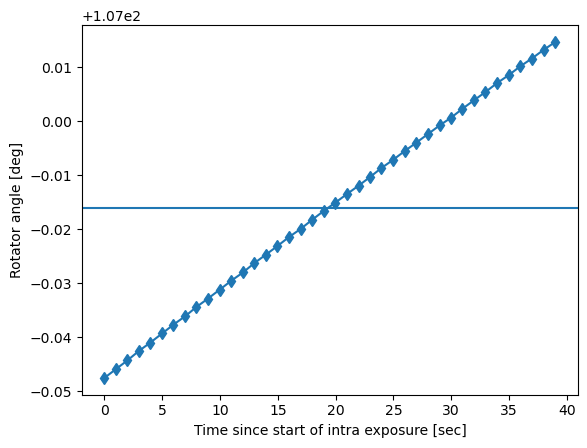

In [200]:
# print in seconds 
dt = rotator['nasmyth2CalculatedAngle99'].index - rotator['nasmyth2CalculatedAngle99'].index[0]
dt_sec = np.array(dt.values.astype(float)) / 1e9
plt.plot(dt_sec, rotator['nasmyth2CalculatedAngle99'].values, marker='d')
plt.xlabel('Time since start of intra exposure [sec]')
plt.ylabel('Rotator angle [deg]')
plt.axhline(rot_pos)

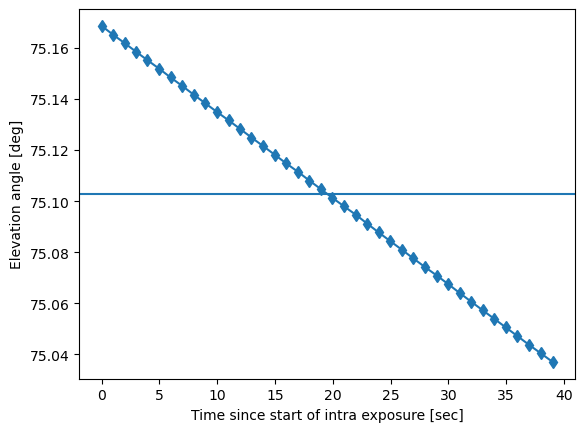

In [203]:
dt = azel['elevationCalculatedAngle99'].index - azel['elevationCalculatedAngle99'].index[0]
dt_sec = np.array(dt.values.astype(float)) / 1e9
plt.plot(dt_sec, azel['elevationCalculatedAngle99'].values, marker='d')
plt.xlabel('Time since start of intra exposure [sec]')
plt.ylabel('Elevation angle [deg]')
plt.axhline(el)

# Inspect the results

The wavefront was measured with rotation  different than 0, and needs to be derotated to the boresight frame.

In general, Zernike terms are either not affected by rotation (eg. defocus term Z4), or they rotate in pairs  (e.g., Z7 & Z8).  For the pairs, the rotation matrix is 

$\begin{bmatrix}
\cos(m*a) & -\sin(m*a) \\
\sin(m*a) & \cos(m*a)
\end{bmatrix}$

where $a$ is the angle in the coordinate system rotation and $m$ is the azimuthal order of the particular Zernike pair.  For coma, $m=1$ so that the rotation matrix has $sin(a)$ and $cos(a)$. For astigmatism, $m=2$ so the matrix contains $sin(2a)$ and $cos(2a)$. Given the maximum number of Zernike terms to rotate, the GalSim function `zernikeRotMatrix` calculates the necessary rotation matrix.


The Noll Zernike expansion terms include x,y components of various moments (astigmatism, coma, trefoil). The total moment is conserved under rotation, and is plotted first as a sanity check, since these quantities do not change under rotation. 

First we plot these total moments -  invariant under rotation: total astigmatism (zk5,6), primary coma 
    (zk7,8), trefoil (zk9,10), etc. 

Note: the original `latiss_base_align` code derotates Zernikes using this [rotation matrix](https://github.com/lsst-ts/ts_externalscripts/blob/a8d2a5191d2230d2875b44a881a878e4bca5cbd4/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py#L128):

$R_{784} = \begin{bmatrix}
   \cos{\theta}   & -\sin{\theta} & 0 \\    
   \sin{\theta} & \cos{\theta} & 0 \\ 
   0 & 0 & 1  
\end{bmatrix}
$
   
   where $\theta = rot - el$. But Galsim `zernikeRotMatrix` rotates in the opposite direction. This can be shown with the following - we load an example set of Zernikes resulting from `ts_wep` fit. We consider only  a subset of $[Zk7,Zk8,Zk4]$. We rotate it first using the $R_{784}(\theta)$ above. Then we rotate with Galsim by $-\theta$, and show that the resulting rotated Zernikes are the same. 

In [223]:
# the rotation matrix used in latiss_base_align
matrix_rotation = lambda angle: np.array(
        [
            [np.cos(np.radians(angle)), -np.sin(np.radians(angle)), 0.0],
            [np.sin(np.radians(angle)), np.cos(np.radians(angle)), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )

# load one set of Zernikes 
seq_num=71
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)
zk4_22 =  butler.get(
            "zernikeEstimateAvg", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        )


In [225]:
# zernikes from ts_wep  is 4:22 ... 
angle = 90 

# that is [comaX, comaY, defocus ]
zk784 = [zk4_22[7-4],zk4_22[8-4],zk4_22[4-4]]

# rotate by angle 
zk784_rot = np.matmul(zk784 , matrix_rotation(angle))
     
zk4_8 = zk4_22[ :9-4]
zk1_8 = np.pad(zk4_8, [4,0]) # pad by 4 so it starts at 0, and array[i] corresponds to zk[i]

# rotate by -angle 
zk1_8_rot_galsim = np.matmul(zk1_8, zernikeRotMatrix(8, -np.deg2rad(angle)))

zk784_rot_galsim = zk1_8_rot_galsim[[7,8,4]]

In [227]:
zk784_rot_galsim

array([-0.1319935 ,  0.32600393, -0.07967852])

In [226]:
zk784_rot

array([-0.1319935 ,  0.32600393, -0.07967852])

Thus the two sets of rotated Zernikes are the same if we use for galsim the `-angle` used in `latiss_base_align` `matrix_rotation`

Now we plot the total moments, to show that they are indeed invariant under rotation:

In [7]:
%matplotlib inline


def plot_derot_total(axis = 'x'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)
    
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
        
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
        
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)  # this is unrotated 4:22 

    # pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)


    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]

        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate by applying matrix multiplication
        # angle = rot - el 
        angle =  d[d['intra'] == intra_name]['angle'].value[0]

        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, -np.deg2rad(angle)))
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)

    titles = {5:'astigmatism', 7:'coma', 9:'trefoil', 
                  12:'2nd astigmatism',14:'quadrafoil',16:'2nd coma',
                  18:'2nd trefoil',20:'pentafoil'}

    # rename rotated 4:22 to use the same plotting code 
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
    axes = axes.ravel()
    xdata = dxs
   
    i = 0 
    for j in titles.keys():
        
        # plot the rotated Zks 
        zk_x = zk1_22_rot_arr[:,j]  # eg. zk5
        zk_y = zk1_22_rot_arr[:,j+1]  # eg, zk6 
        ydata = np.sqrt(zk_x**2. + zk_y**2.)
        axes[i].scatter(xdata, ydata, marker='d',s=95, label='original')
        
        # plot the unrotated Zks 
        zk_x = zk1_22_arr[:,j]
        zk_y = zk1_22_arr[:,j+1]
        ydata = np.sqrt(zk_x**2. + zk_y**2.)
        axes[i].scatter(xdata, ydata, marker='s', label='rotated')
        
        axes[i].set_title(f"Z{j,j+1}: {titles[j]}")

        i += 1

    for ax in axes:
        ax.set_ylim(0., 0.36)
        ax.axhline(0, c='k')
    fig.text(0.44,0, f"M2 d{axis} [mm]", fontsize=14)
    fig.text(-0.02
             ,0.4,"WFE [µm]", rotation='vertical',fontsize=14 )
    plt.tight_layout()
    plt.show()


In [5]:
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

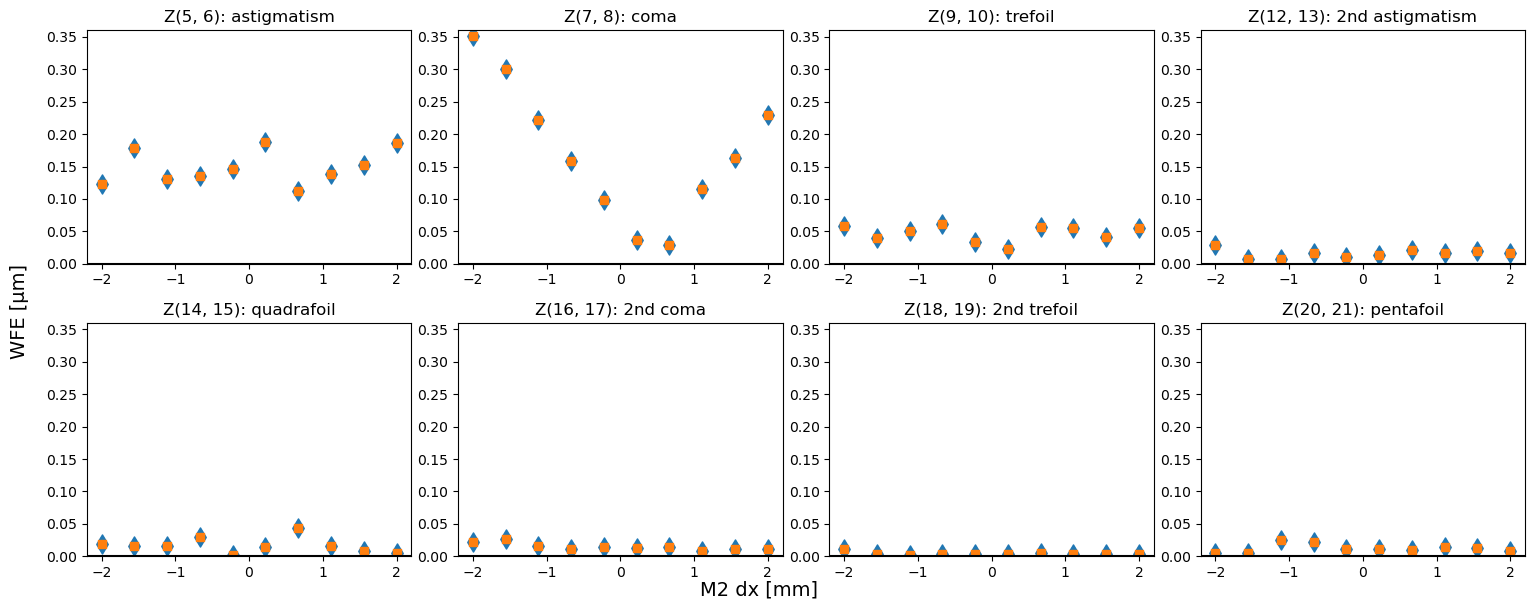

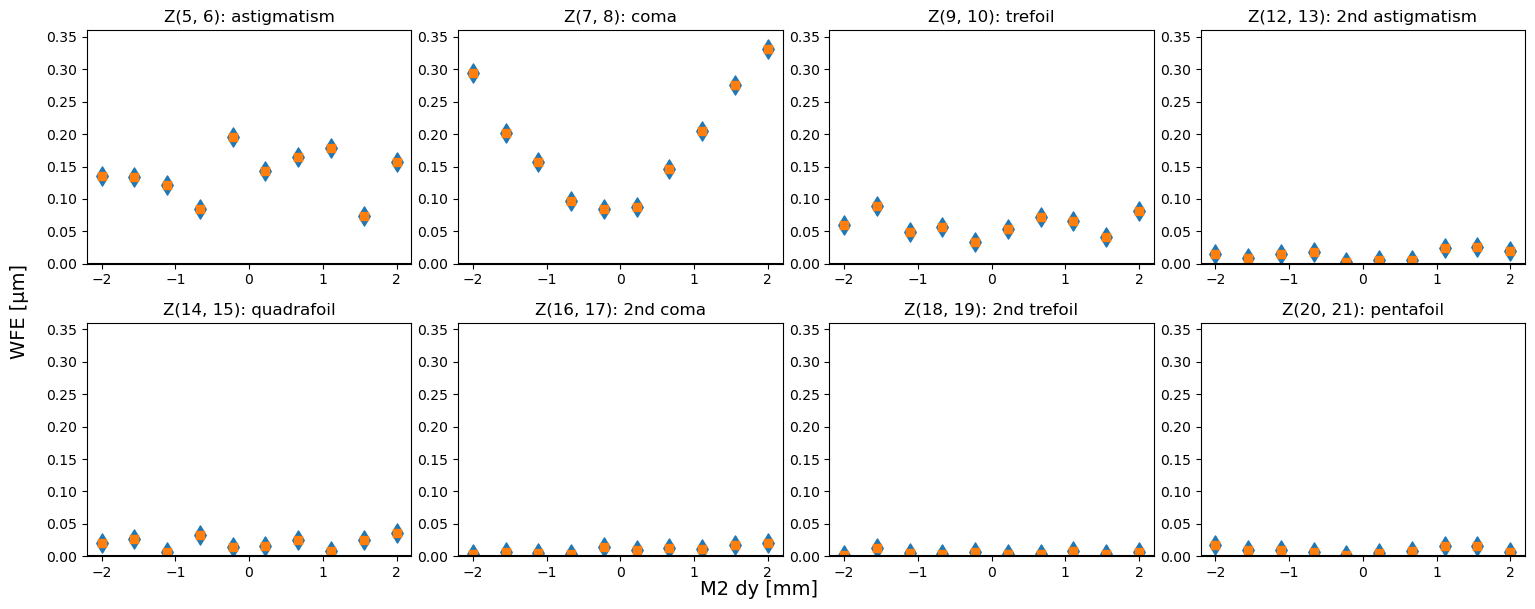

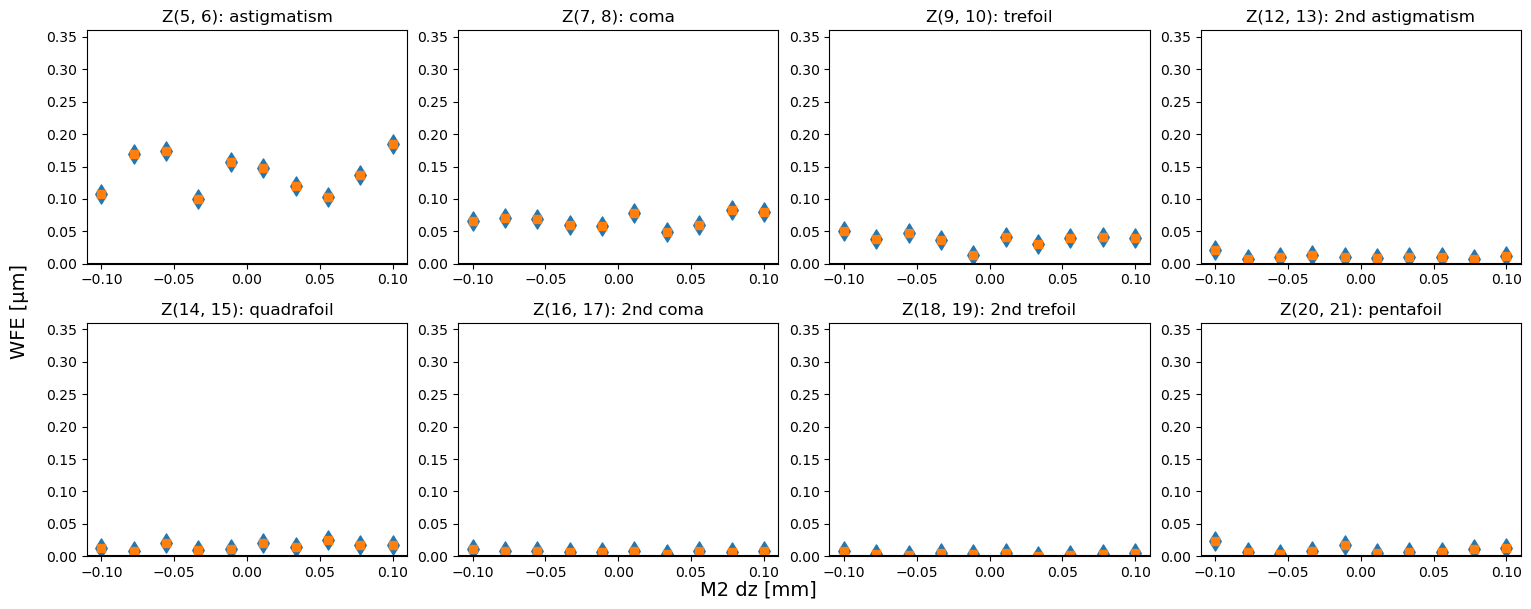

In [8]:
for axis in 'xyz':
    plot_derot_total(axis = axis)

Blue diamonds are original (rotated), and  orange squares are derotated Zernike values. They are identical because the total coma / astigmatism / trefoil is invariant under rotation. 

# Plot only a subset of Zernikes relevant to sensitivity matrix calculation (defocus, comaX, comaY)

In [100]:

def plot_sens_rot_zk478(axis = 'x', verbose=True, add_angle=0, mult_angle = 1, swap_xy_coma = True,
                       pre = '-'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)  
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
    
    # read in the appropriate Zernike coefficients 
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)

    # first, pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)

    # now derotate using the  EFD angle = el-rot 
    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]
        if  swap_xy_coma : 
            # swap x,y coma ... 
            x_coma = zk1_22_unrot[7]
            y_coma = zk1_22_unrot[8]
            zk1_22_unrot[7] = y_coma
            zk1_22_unrot[8] = x_coma
        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate using angle = rot-el 
        #                      = Nasmyth2CalculatedAngle- elevationCalculatedAngkle
        angle =  d[d['intra'] == intra_name]['angle'].value[0]

        # in the latiss_base_align, the rotation is by 
        # angle + camera_rotation_angle, where
        # camera_rotation_angle is orientation of the 
        # detector relative to the rotator, 
        # assumed to be within a degree or two 
        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, 
                              np.deg2rad(add_angle+mult_angle*angle)))
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)
    
    # plot the derotated and the rotated Zks 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    axes = axes.ravel()
    xdata = dxs
    
    # rotated
    if verbose:
        print('\n Rotated ')
    col=0
    
    slopes = []
    for j in [7,8,4]: # range(4, 23): 
        ydata = 1000*zk1_22_rot_arr[:,j] # use nm 
        axes[col].scatter(dxs, ydata,)
        
        # fit straight line 
        x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
        popt,pcov = curve_fit(line, xdata, ydata)
        if verbose:
            print(f'Z{j} as func of dx displacement fit intercept and slope ',popt)
        axes[col].plot(x,line(x, *popt),
         label=f'fit slope {np.round(popt[1],1)}nm / mm', alpha=0.8)
        axes[col].set_ylabel(f'Z{j} [nm]')
        col += 1 
        if verbose: print('1/slope=', 1/popt[1])
        
        slopes.append(popt[1])
        
    # The original senM we're comparing to: 
    #     self.matrix_sensitivity = [
    #             [1.0 / 206.0, 0.0, 0.0],
    #             [0.0, -1.0 / 206.0, -(109.0 / 206.0) / 4200],
    #             [0.0, 0.0, 1.0 / 4200.0],
    #         ]
    xleg = 0
    yleg = 1.2 
    loc_string = 'lower left'
    
    mult = int(pre+'1')
    # we're plottting   zk7, zk8  ,zk4 
    if axis == 'x':
        # dx slopes 
        # Z7 as a function of dx : Cx 
        ax_idx = 0 # zk7
        popt = [+7.20791437, mult*206]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string, bbox_to_anchor=(xleg, yleg ))
        
    
    elif axis == 'y':
        # dy slopes 
        # z4: defocus as function of dy : Czy  
        ax_idx = 2
        
        popt = [+7.20791437, mult*(-109)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string,bbox_to_anchor=(xleg, yleg ))

        # Z8 (comaY) as function of dy : Cy 
        ax_idx = 1
        popt = [+7.20791437, mult*(-206)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string, bbox_to_anchor=(xleg, yleg ))
        
    elif axis == 'z':
        # dz slopes
        # Z4: defocus as function of dz : Dz
        ax_idx = 2
        popt = [+7.20791437, mult*4200]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=[0,1], bbox_to_anchor=(xleg, yleg ))


    for ax in axes:#[:-1]:
        ax.set_ylim(-300, 300)
        ax.axhline(0, c='k')
        #ax.set_ylabel()
        ax.set_xlabel(f"M2 d{axis} [mm]")
        
    fig.suptitle(f'Rotation by  Galsim({add_angle} + {mult_angle}*angle), slope= {pre}senM term', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return slopes 

Without the transpose, needed to swap comaX and comaY to have similar slopes to those in senM:


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [60.8300747 -145.1969833]
1/slope= -0.006887195430427816
Z8 as func of dx displacement fit intercept and slope  [29.6122902 -7.2710867]
1/slope= -0.13753102341606224
Z4 as func of dx displacement fit intercept and slope  [-42.7066438 -5.2598979]
1/slope= -0.19011775909558462


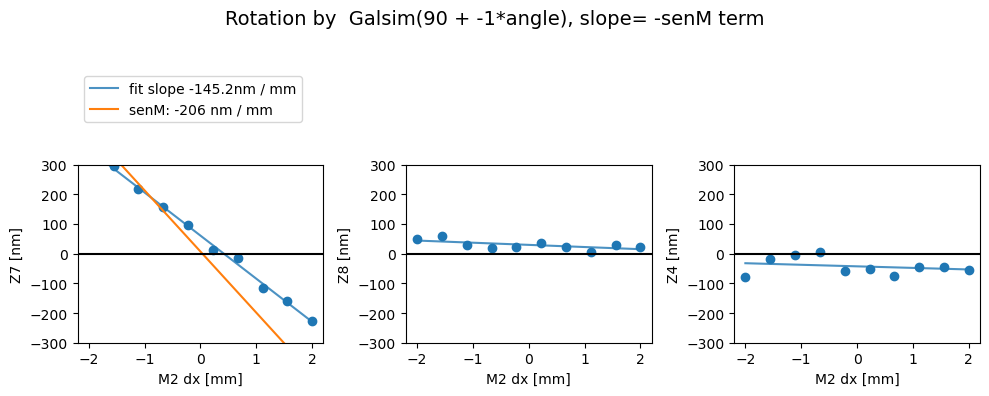


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [54.6707430 1.4491803]
1/slope= 0.6900452798460964
Z8 as func of dx displacement fit intercept and slope  [24.8402386 153.6650160]
1/slope= 0.006507662094735284
Z4 as func of dx displacement fit intercept and slope  [-57.2261476 18.1785362]
1/slope= 0.0550099296449157


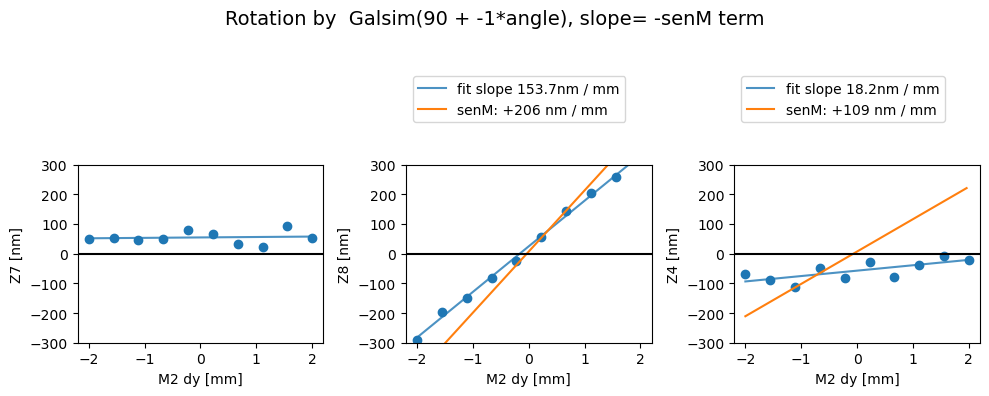


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [65.8535825 27.9450592]
1/slope= 0.03578450106274538
Z8 as func of dx displacement fit intercept and slope  [-3.1745337 45.1294304]
1/slope= 0.022158489308368588
Z4 as func of dx displacement fit intercept and slope  [-47.6947738 -3894.9107970]
1/slope= -0.00025674528946318607


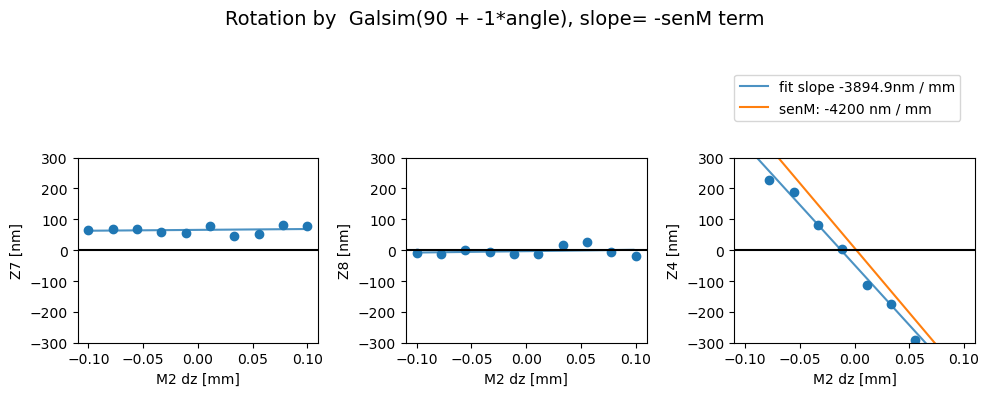

In [54]:
output_collection = 'u/scichris/latiss_230310_run/wep_no_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

for axis in 'xyz':
    slopes = plot_sens_rot_zk478(axis=axis, add_angle=90, mult_angle = -1)

With the transpose, there's no need to swap the comaX with comaY  -the slopes are as we'd expect (i.e. there's a comaX dependence on `dx`, and comaY dependence on `dy`):


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [60.8301 -145.1970]
1/slope= -0.006887195432668731
Z8 as func of dx displacement fit intercept and slope  [29.6123 -7.2711]
1/slope= -0.13753102315714963
Z4 as func of dx displacement fit intercept and slope  [-42.7066 -5.2599]
1/slope= -0.19011776980762635


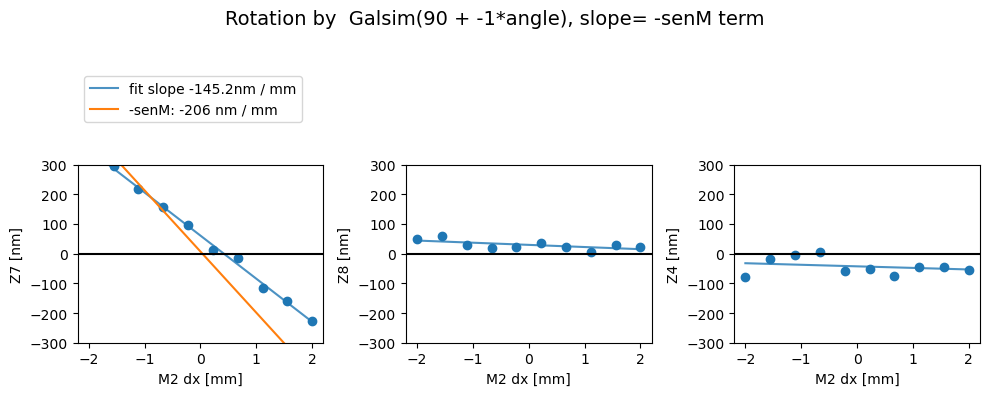


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [54.6707 1.4492]
1/slope= 0.6900452025297202
Z8 as func of dx displacement fit intercept and slope  [24.8402 153.6650]
1/slope= 0.006507662094735288
Z4 as func of dx displacement fit intercept and slope  [-57.2261 18.1785]
1/slope= 0.05500992957311213


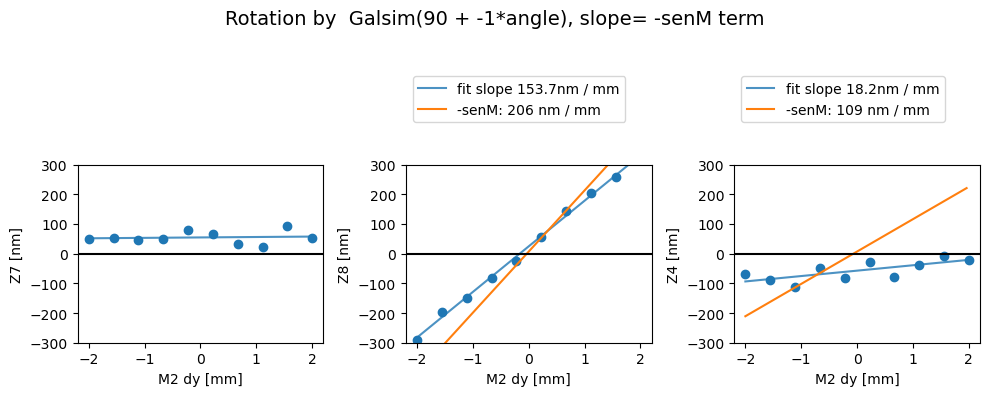


 Rotated 
Z7 as func of dx displacement fit intercept and slope  [65.8536 27.9451]
1/slope= 0.03578450422403263
Z8 as func of dx displacement fit intercept and slope  [-3.1745 45.1294]
1/slope= 0.022158489610733374
Z4 as func of dx displacement fit intercept and slope  [-47.6948 -3894.9108]
1/slope= -0.00025674528940569554


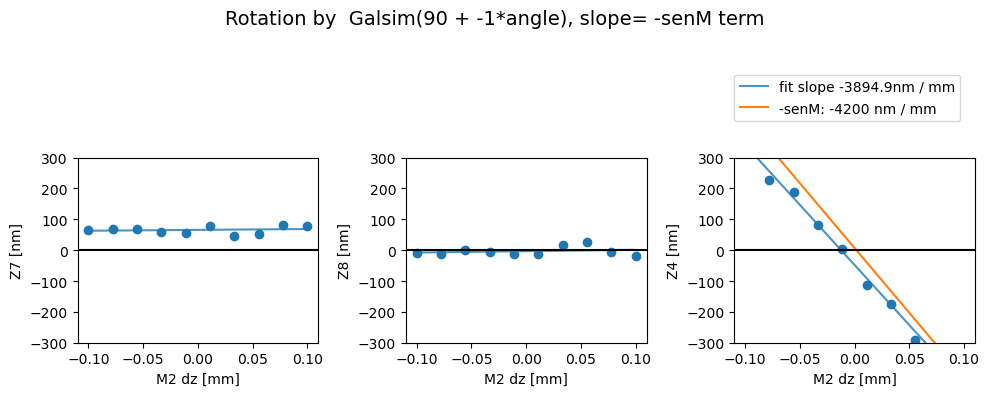

In [101]:
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

slope_dic = {}
for axis in 'xyz':
    slopes = plot_sens_rot_zk478(axis=axis, add_angle=90, mult_angle = -1, swap_xy_coma=False,
                                pre='-')
    slope_dic[axis] = slopes

In [56]:
slope_dic

{'x': [-145.19698326790595, -7.2710867486047235, -5.259897594064277],
 'y': [1.4491804251866094, 153.66501601381577, 18.17853627081868],
 'z': [27.94505671335826, 45.12942973855082, -3894.910797836887]}

We have measured directly the slopes that form the following Jacobian: 
    
```
[Z7]   [ dZ7/dx  dZ7/dy  dZ7/dz ]   [dx]
[Z8] = [ dZ8/dx  dZ8/dy  dZ8/dz ] * [dy]  = J * X
[Z4]   [ dZ4/dx  dZ4/dy  dZ4/dz ]   [dz]
```

In [57]:
J = np.array([slope_dic['x'], slope_dic['y'], slope_dic['z']]).T

In [58]:
np.set_printoptions(formatter={'float_kind':'{:.8f}'.format})

In [59]:
J

array([[-145.19698327, 1.44918043, 27.94505671],
       [-7.27108675, 153.66501601, 45.12942974],
       [-5.25989759, 18.17853627, -3894.91079784]])

The sensitivity matrix is the inverse of that Jacobian:

In [102]:
M = -np.linalg.inv(J)

In [103]:
np.set_printoptions(formatter={'float_kind':'{:.4f}'.format})

In [104]:
M*1000

array([[6.8890, -0.0707, 0.0486],
       [0.3283, -6.5021, -0.0730],
       [-0.0078, -0.0303, 0.2563]])

Compare that to the original matrix:

In [105]:
M0 = np.array([[1.0 / 206.0,      0.0,                       0.0],
[ 0.0,          -1.0 / 206.0,     -(109.0 / 206.0) / 4200],
[ 0.0,             0.0,                      1.0 / 4200.0]])

In [106]:
M0*1000

array([[4.8544, 0.0000, 0.0000],
       [0.0000, -4.8544, -0.1260],
       [0.0000, 0.0000, 0.2381]])

Thus we have that the new sensitivity matrix would be : 



In [108]:
np.set_printoptions(formatter={'float_kind':'{:.8f}'.format})
M

array([[0.00688898, -0.00007072, 0.00004861],
       [0.00032825, -0.00650212, -0.00007298],
       [-0.00000777, -0.00003025, 0.00025634]])

# Plot all derotated Zernikes as a function of hexapod motion 

For completeness, we also plot all other measured Zernikes (besides Z7,Z8,Z4 considered for sensitivity matrix) as a function of hexapod motion.


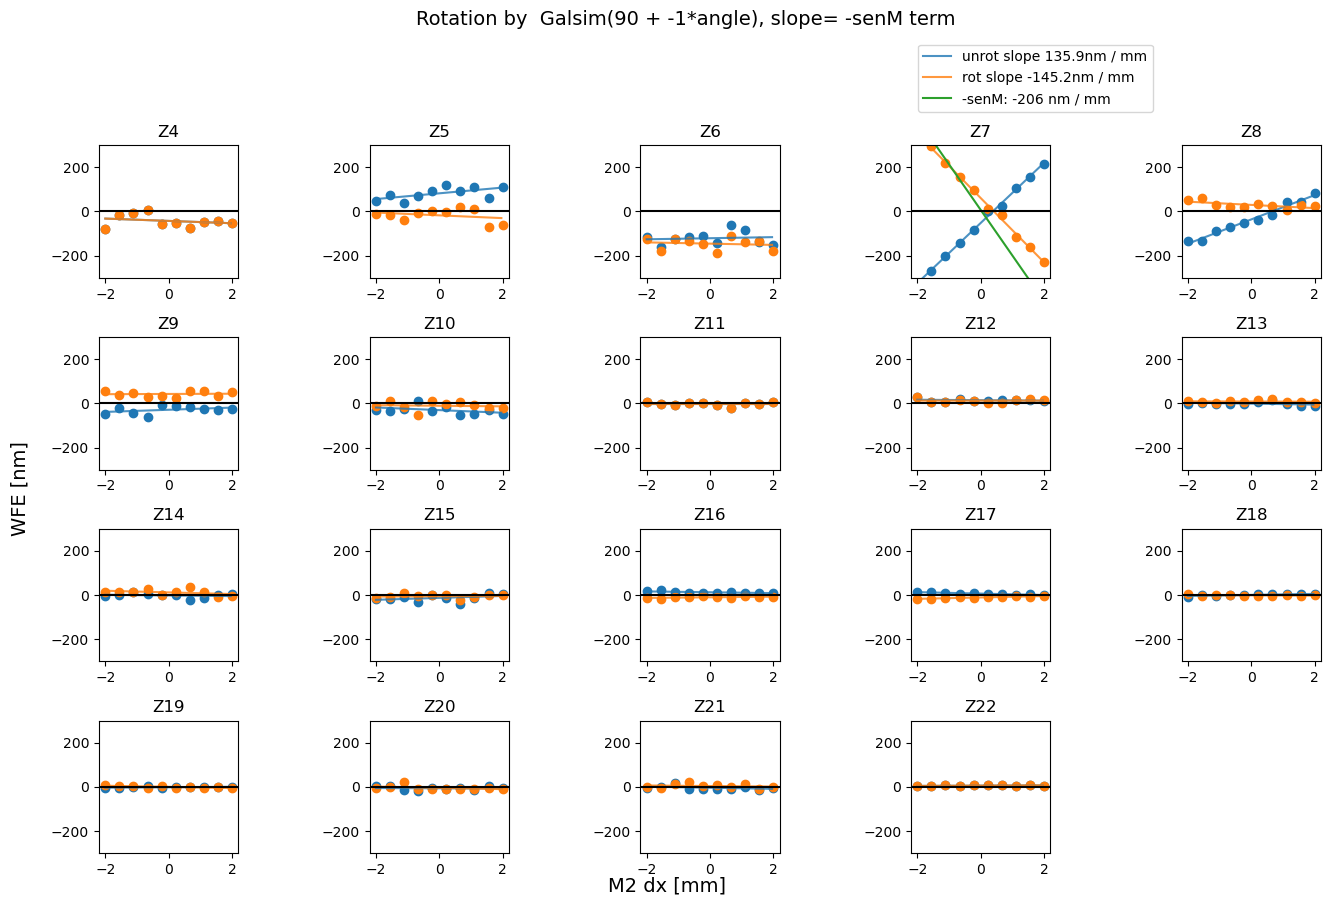

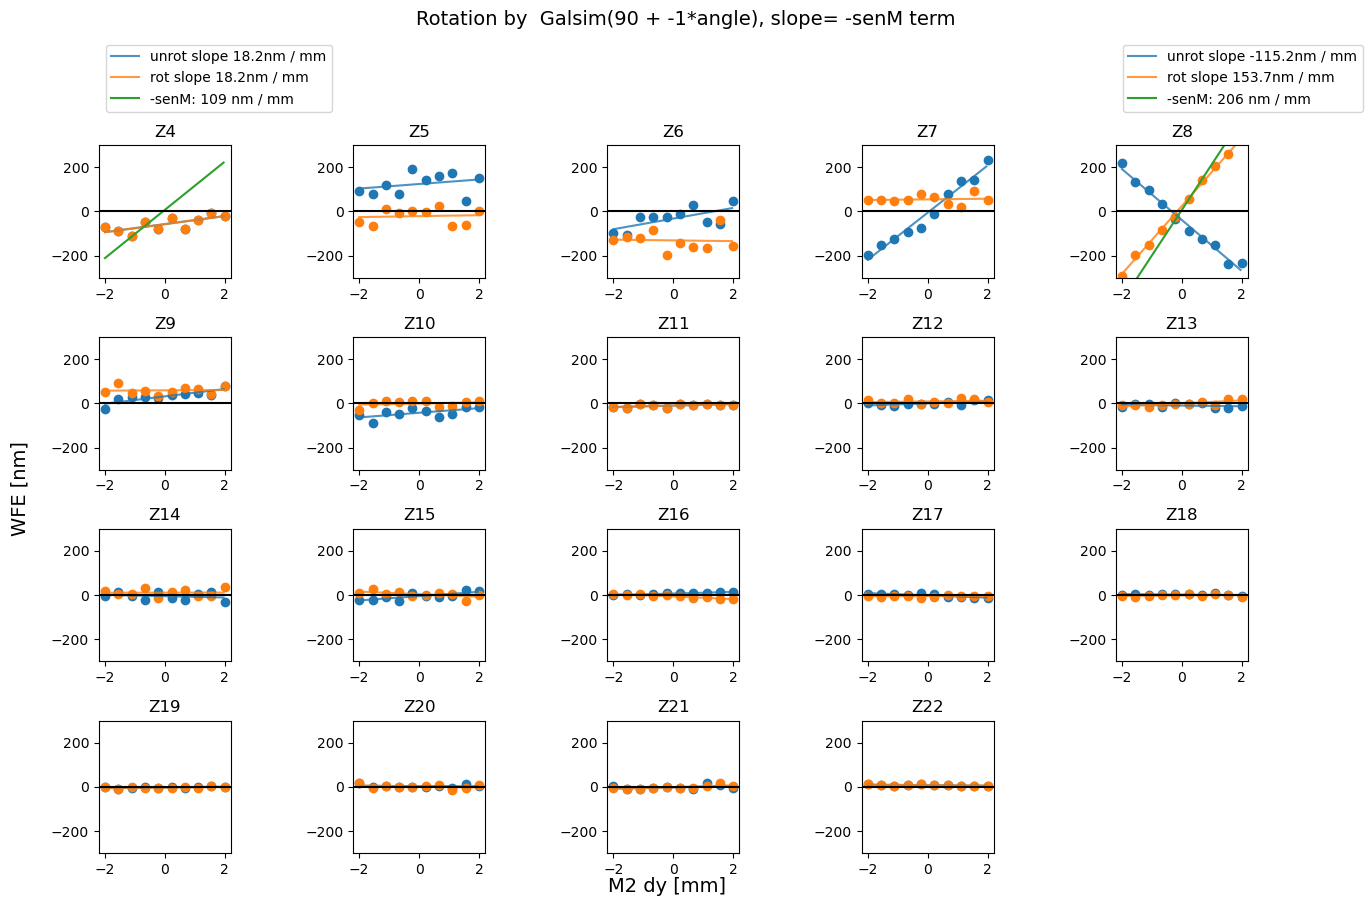

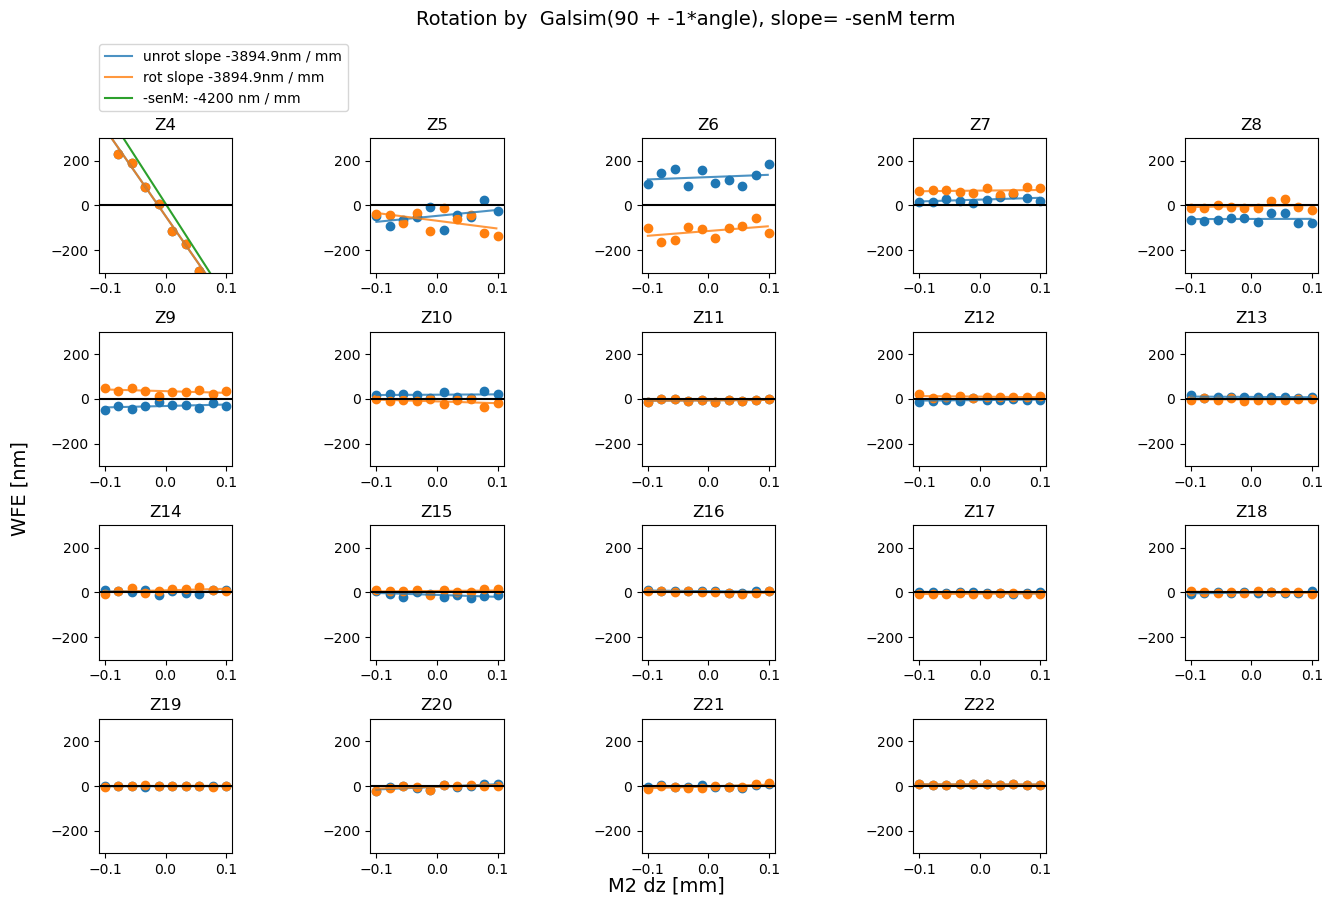

In [112]:
def line(x,b, m):
    return b + m*x 


d = Table.read('20230310_EFD_angle_data.txt', format='ascii')
d['angle'] = d['rot'] - d['el']


def plot_sens_rot(axis = 'x', verbose=True, add_angle=0, mult_angle = 1, pre='-'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)
    
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
        
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
    
    # read in the appropriate zernikes 
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)
    
    # first, pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)

    # now derotate using the  EFD angle = el-rot 
    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]

        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate by applying matrix multiplication
        angle =  d[d['intra'] == intra_name]['angle'].value[0]
        
        # derotate using angle = rot-el 
        #                      = Nasmyth2CalculatedAngle- elevationCalculatedAngkle
        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, np.deg2rad(add_angle+mult_angle*angle)))
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)
    
    # plot the derotated and the rotated Zks 
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(13, 9))
    axes = axes.ravel()
    xdata = dxs
    
    
    # unrotated
    if verbose: print('\n Unrotated ')
    for j in range(4, 23):  
        ydata = 1000*zk1_22_arr[:,j] # use nm 
        axes[j-4].scatter(dxs, ydata,)# label='unrot')
        
        # fit straight line 
        x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
        popt,pcov = curve_fit(line, xdata, ydata)
        if verbose:
            print(f'Z{j} as func of dx displacement fit intercept and slope ',popt)
        axes[j-4].plot(x,line(x, *popt),
         label=f'unrot slope {np.round(popt[1],1)}nm / mm', alpha=0.8)

        if verbose: print('1/slope=', 1/popt[1])
        
        axes[j-4].set_title(f"Z{j}")
    
    # rotated
    if verbose:
        print('\n Rotated ')
    for j in range(4, 23):  
        ydata = 1000*zk1_22_rot_arr[:,j] # use nm 
        axes[j-4].scatter(dxs, ydata,)# label='rot' )
        
        # fit straight line 
        x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
        popt,pcov = curve_fit(line, xdata, ydata)
        if verbose:
            print(f'Z{j} as func of dx displacement fit intercept and slope ',popt)
        axes[j-4].plot(x,line(x, *popt),
         label=f'rot slope {np.round(popt[1],1)}nm / mm', alpha=0.8)

        if verbose: print('1/slope=', 1/popt[1])
        
    # Plot slopes based on 
    #     self.matrix_sensitivity = [
    #             [1.0 / 206.0, 0.0, 0.0],
    #             [0.0, -1.0 / 206.0, -(109.0 / 206.0) / 4200],
    #             [0.0, 0.0, 1.0 / 4200.0],
    #         ]
    # location of legend bbox 
    xleg = 0
    yleg = 1.2 
    loc_string = 'lower left'
    
    # multiplication factor of the original sensitivity matrix terms ... 
    mult = int(pre+'1') 
    
    # we're plottting   zk7, zk8  ,zk4 
    zk0 = 4 # starting from Zk4.... 
    if axis == 'x':
        # dx slopes 
        # Z7 as a function of dx : Cx 
        ax_idx = 7-zk0 # zk7
        popt = [+7.20791437, mult*206]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string, bbox_to_anchor=(xleg, yleg ))
    
    
    elif axis == 'y':
        # dy slopes 
        # defocus as function of dy : Czy  
        ax_idx = 4-zk0
        
        popt = [+7.20791437, mult*(-109)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string,bbox_to_anchor=(xleg, yleg ))

        # Z8 (comaY) as function of dy : Cy 
        ax_idx = 8-zk0
        popt = [+7.20791437, mult*(-206)]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=loc_string, bbox_to_anchor=(xleg, yleg ))
        
    elif axis == 'z':
        # dz slopes
        # defocus as function of dz : Dz
        ax_idx = 4-zk0
        popt = [+7.20791437, mult*4200]    
        axes[ax_idx].plot(x, line(x,*popt), label=f'{pre}senM: {popt[1]} nm / mm')
        axes[ax_idx].legend(loc=[0,1], bbox_to_anchor=(xleg, yleg ))


    for ax in axes[:-1]:
        ax.set_ylim(-300, 300)
        ax.axhline(0, c='k')
        
    # add just one set of labels     
    fig.text(0.44, 0,  f"M2 d{axis} [mm]", fontsize=14)
    fig.text(-0.02 ,0.4,"WFE [nm]", rotation='vertical',fontsize=14 )
    
    axes[-1].axis('off')
    fig.suptitle(f'Rotation by  Galsim({add_angle} + {mult_angle}*angle), slope= {pre}senM term', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

for axis in 'xyz':
    plot_sens_rot(axis=axis, add_angle=90, mult_angle = -1, verbose=False)

Future improvements:

* how could we utilize  the additional information conveyed in Z5,Z6,Z9:22 ?  
* how could we estimate uncertainty in Zernike estimation?  One way would be PSSN-based, but there's only one value of PSSN per entire exposure... Perhaps the scatter from the 5 brightest sources?  But at least for auxTel cwfs, fields are not chosen to necessarily contain more than 1 bright source, so there could be a porfectly fine image containing a very bright primary target, and multiple faint ones, which are so faint that the scatter would be much larger than for a field that is perhaps of worse atmospheric condition, but that contains several stars of similar brightness...  Perhaps residuals of model(final Zernike estimate)-image, which would require the evaluation of estimated wavefront and transforming it to the image plane...? 